# 設定

In [ ]:
!pip install japanize-matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import scipy
from scipy import stats
import copy
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
from matplotlib.collections import LineCollection

# 1.1回帰の例

In [ ]:
kidney = pd.read_csv("/content/kidney.txt", delimiter=" ")

## 図1.1

In [ ]:
model = smf.ols(formula="tot ~ age", data=kidney)
results = model.fit()

In [ ]:
sorted_kidney = kidney.sort_values("age")
tot_pred = results.predict(sorted_kidney)

In [ ]:
decades = pd.DataFrame({"age": range(20, 90, 10)})

In [ ]:
pred = results.get_prediction(decades)
pred_info = pred.summary_frame()
pred_info.index = decades.age

In [ ]:
pred_info

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
age,,,,,,
20,1.288258,0.206648,0.880048,1.696469,-2.292802,4.869319
30,0.502374,0.154965,0.196259,0.808490,-3.068490,4.073238
40,-0.283510,0.147398,-0.574678,0.007659,-3.853123,3.286104
50,-1.069394,0.189314,-1.443363,-0.695425,-4.646713,2.507926
60,-1.855278,0.257595,-2.364127,-1.346429,-5.449202,1.738646
70,-2.641162,0.336559,-3.305996,-1.976329,-6.260467,0.978142
80,-3.427046,0.420226,-4.257155,-2.596937,-7.080325,0.226232


In [ ]:
se_lines = LineCollection(
    [
        [[age, pred - 2 * se], [age, pred + 2 * se]]
        for age, pred, se in zip(pred_info.index, pred_info["mean"], pred_info["mean_se"])
    ],
    color="k"
)

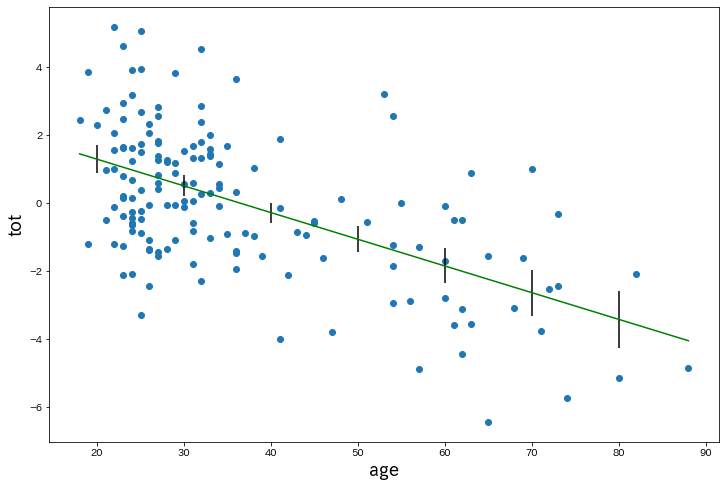

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(kidney.age, kidney.tot)
ax.plot(sorted_kidney.age, tot_pred, color="g")
ax.add_collection(se_lines)

ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);

## 図1.2

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [ ]:
low_preds = lowess(kidney.tot, kidney.age, frac=1/3.0)

In [ ]:
low_boots = []
for i in range(250):
    boot_data = kidney.sample(n=kidney.shape[0], replace=True)
    new_preds = lowess(boot_data.tot, boot_data.age, frac=1/3.0)
    low_boots.append(new_preds)

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
ages = np.array(list(range(20, 90, 10)))

In [ ]:
# interpolate lowess predictions for age = 20, 30, ..., 80
dec_preds = np.zeros((7, 250))
for i, pred in enumerate(low_boots):
    # interp1d seems to have trouble with non-unique values
    pred = np.unique(pred, axis=0)
    # create an interpolator and collect each lowess's predictions
    interpolate = interp1d(pred[:, 0], pred[:, 1], fill_value="extrapolate", assume_sorted=True)
    dec_preds[:, i] = interpolate(ages)

# get standard deviation for each age
var = np.var(dec_preds, axis=1, ddof=1)
sds = np.sqrt(var)

In [ ]:
# interpolate/predict from the original lowess predictions
interpolate = interp1d(
    low_preds[:, 0],
    low_preds[:, 1],
    fill_value="extrapolate",
    assume_sorted=True
)

se_lines = LineCollection(
    [
        [[age, interpolate(age) - 2 * se], [age, interpolate(age) + 2 * se]]
        for age, se in zip(ages, sds)
    ],
    color="k"
)

In [ ]:
print(sds)

[0.60568563 0.25456555 0.31100737 0.3133979  0.37403135 0.51613517
 0.77171833]


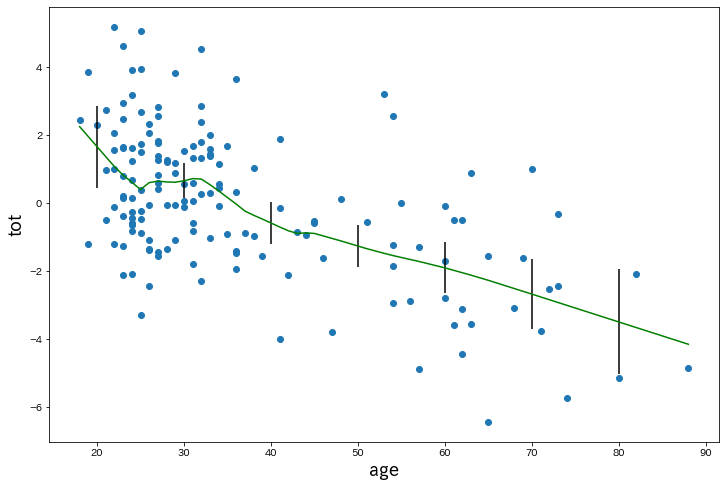

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(kidney.age, kidney.tot)
ax.plot(low_preds[:, 0], low_preds[:, 1], color="g")
ax.add_collection(se_lines)

ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);

##図1.3

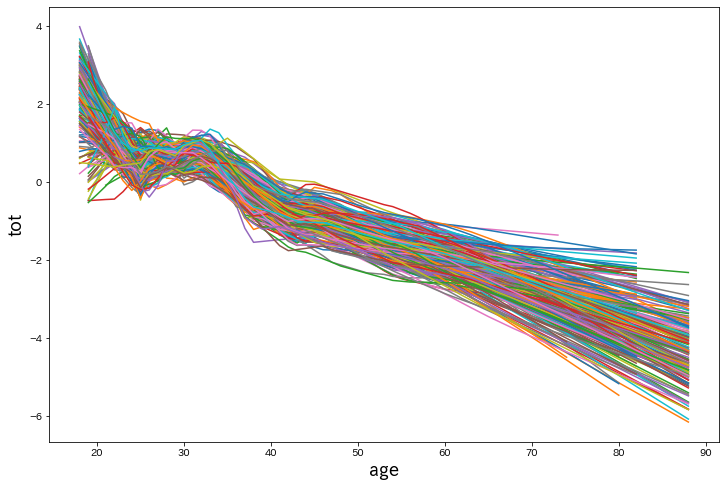

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

for preds in low_boots[:250]:
    ax.plot(preds[:, 0], preds[:, 1])

ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);

# 1.2　仮設検定

In [ ]:
leukemia = pd.read_csv("/content/leukemia_big.csv")

## 図1.4

In [ ]:
leukemia_136=leukemia.iloc[135]

In [ ]:
leukemia_136.index

Index(['ALL', 'ALL.1', 'ALL.2', 'ALL.3', 'ALL.4', 'ALL.5', 'ALL.6', 'ALL.7',
       'ALL.8', 'ALL.9', 'ALL.10', 'ALL.11', 'ALL.12', 'ALL.13', 'ALL.14',
       'ALL.15', 'ALL.16', 'ALL.17', 'ALL.18', 'ALL.19', 'AML', 'AML.1',
       'AML.2', 'AML.3', 'AML.4', 'AML.5', 'AML.6', 'AML.7', 'AML.8', 'AML.9',
       'AML.10', 'AML.11', 'AML.12', 'AML.13', 'ALL.20', 'ALL.21', 'ALL.22',
       'ALL.23', 'ALL.24', 'ALL.25', 'ALL.26', 'ALL.27', 'ALL.28', 'ALL.29',
       'ALL.30', 'ALL.31', 'ALL.32', 'ALL.33', 'ALL.34', 'ALL.35', 'ALL.36',
       'ALL.37', 'ALL.38', 'ALL.39', 'ALL.40', 'ALL.41', 'ALL.42', 'ALL.43',
       'ALL.44', 'ALL.45', 'ALL.46', 'AML.14', 'AML.15', 'AML.16', 'AML.17',
       'AML.18', 'AML.19', 'AML.20', 'AML.21', 'AML.22', 'AML.23', 'AML.24'],
      dtype='object')

In [ ]:
ALL_136 = leukemia_136[leukemia_136.index.str.contains("ALL")]
AML_136 = leukemia_136[leukemia_136.index.str.contains("AML")]

Text(0.5, 1.0, 'AML')

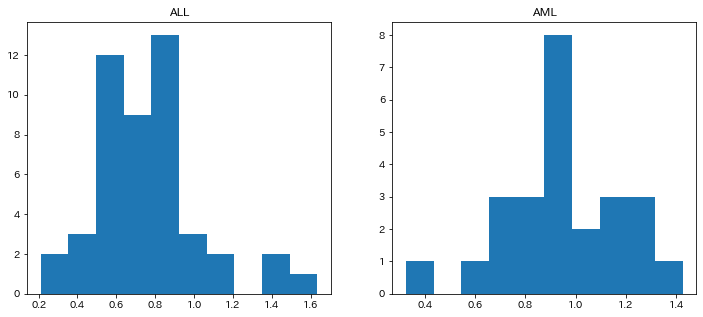

In [ ]:
fig ,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(ALL_136)
ax[1].hist(AML_136)
ax[0].set_title('ALL')
ax[1].set_title('AML')

In [ ]:
ALL_136.mean()

0.7524793960638297

In [ ]:
AML_136.mean()

0.94997308076

## 図1.5

In [ ]:
t_list=[]
for i in range(7128):
  ALL=leukemia.iloc[i][leukemia.iloc[i].index.str.contains("ALL")]
  AML=leukemia.iloc[i][leukemia.iloc[i].index.str.contains("AML")]
  n_1=len(ALL)
  n_2=len(AML)
  sigma_hat=np.sqrt((n_1*ALL.var()+n_2*AML.var())/(n_1+n_2-2))
  sd_hat=sigma_hat*np.sqrt(1/n_1+1/n_2)
  t_=(AML.mean()-ALL.mean())/sd_hat
  t_list.append(t_)

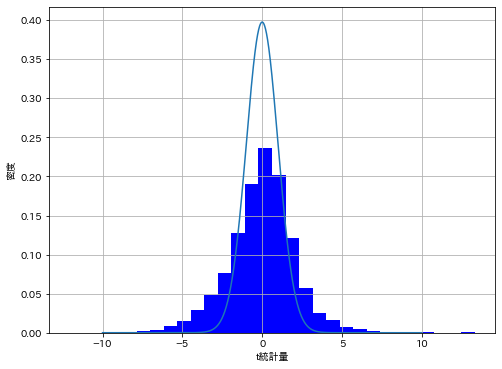

In [ ]:
from scipy.stats import t
plt.figure(figsize=(8,6))
x=np.arange(-10,10,0.01)
plt.hist(t_list,bins=30,density=True,color='blue')
plt.plot(x,t(70).pdf(x))
plt.xlabel('t統計量')
plt.ylabel('密度')
plt.grid(True)    